## Home Credit Default Risk
### Business Problem
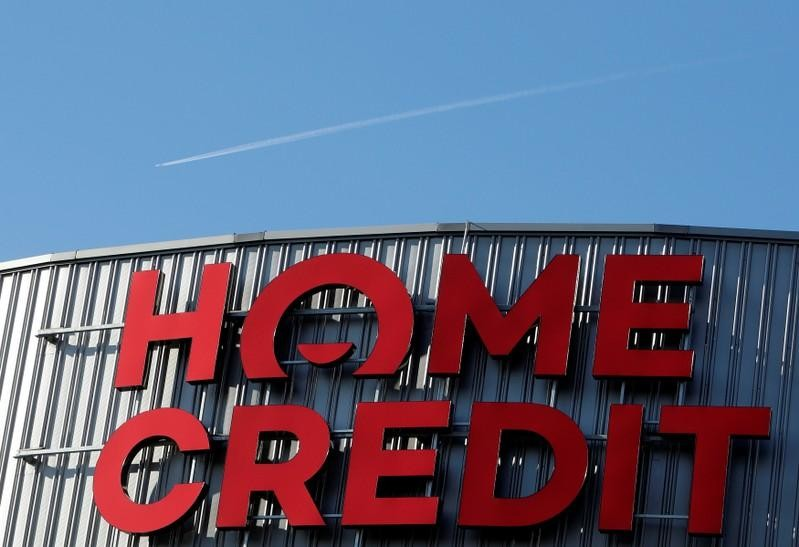

Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.

Home Credit Group

Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

### Task
- Ensure that clients capable of repayment are not rejected
- Loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
path_names = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        path_names.append(os.path.join(dirname, filename))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Part 1: Exploratory Data Analysis

- **application_{train|test}.csv**

This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
Static data for all applications. One row represents one loan in our data sample.
- **bureau.csv**

All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.
- **bureau_balance.csv**

Monthly balances of previous credits in Credit Bureau.
This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.
- **POS_CASH_balance.csv**

Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.
- **credit_card_balance.csv**

Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.
- **previous_application.csv**

All previous applications for Home Credit loans of clients who have loans in our sample.
There is one row for each previous application related to loans in our data sample.
- **installments_payments.csv**

Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
There is a) one row for every payment that was made plus b) one row each for missed payment.
One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.
- **HomeCredit_columns_description.csv**

This file contains descriptions for the columns in the various data files.

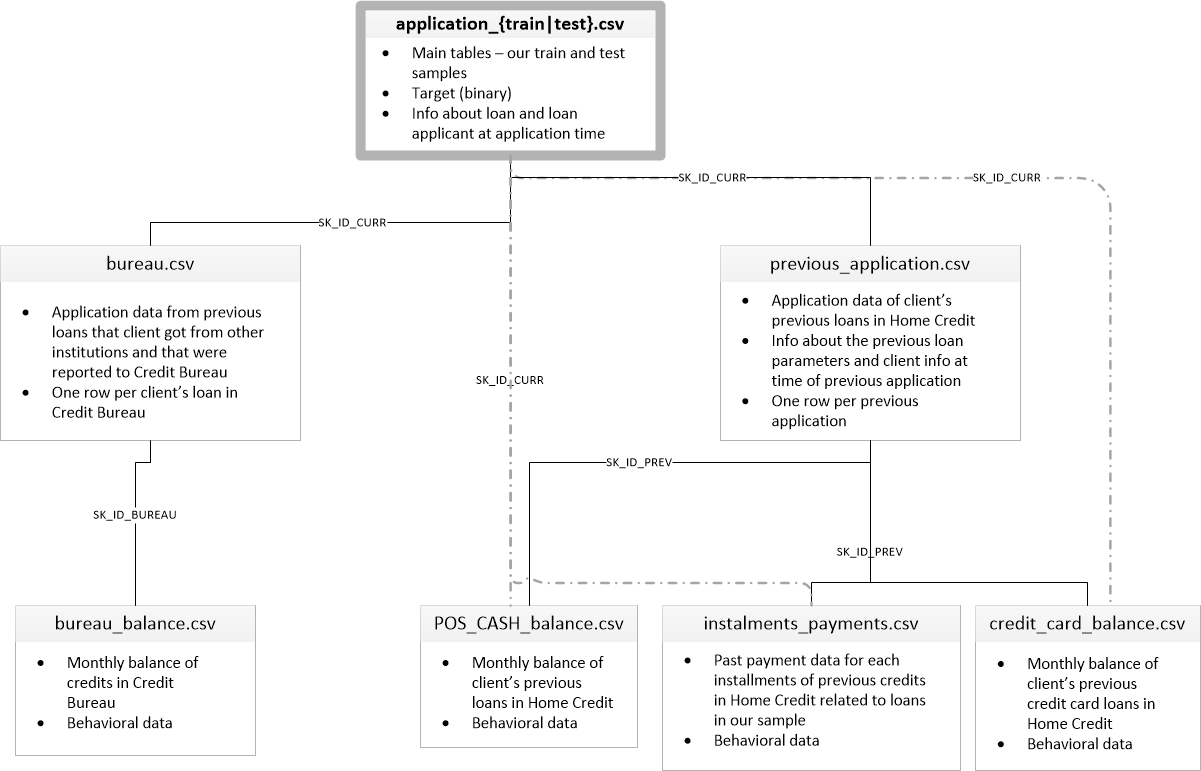


In [ ]:
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,confusion_matrix
from sklearn.linear_model import LogisticRegression # For Logistic Regression Model
from sklearn.tree import DecisionTreeClassifier # For Desicion Tree Classification Model
from sklearn.ensemble import RandomForestClassifier # For Random Forest Classification Model
from sklearn.model_selection import GridSearchCV # For hyperparameters tuning
from sklearn.preprocessing import LabelEncoder # For converted categorical variables to numerical variables
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,roc_auc_score
import plotly.express as px

In [ ]:
bureau = pd.read_csv(path_names[9])
print(bureau.head())
print(bureau.shape)
print(bureau.info())
print(bureau.describe())

### 1.1 Dataset
### Dataset: Bureau
**There are 1,716,428 records in this dataset and 17 columns.**
- SK_ID_CURR: ID of loan in our sample - one loan in our sample can have 0,1,2 or more related previous credits in credit bureau
- SK_BUREAU_ID: Recoded ID of previous Credit Bureau credit related to our loan (unique coding for each loan application)
- CREDIT_ACTIVE: Status of the Credit Bureau (CB) reported credits ('Closed', 'Active', 'Sold', 'Bad debt') categorical
- CREDIT_CURRENCY: Recoded currency of the Credit Bureau credit ('currency 1' 'currency 2' 'currency 4' 'currency 3''currency 4') categorical
- DAYS_CREDIT: How many days before current application did client apply for Credit Bureau credit ( min: -2922, max:0) numerical
- CREDIT_DAY_OVERDUE: Number of days past due on CB credit at the time of application for related loan in our sample(min:0, max:2792) numerical
- DAYS_CREDIT_ENDDATE: Remaining duration of CB credit (in days) at the time of application in Home Credit.numerical
- DAYS_ENDDATE_FACT: Days since CB credit ended at the time of application in Home Credit (only for closed credit) numerical
- AMT_CREDIT_MAX_OVERDUE: Maximal amount overdue on the Credit Bureau credit so far (at application date of loan in our sample)
- CNT_CREDIT_PROLONG: How many times was the Credit Bureau credit prolonged
- AMT_CREDIT_SUM: Current credit amount for the Credit Bureau credit
- AMT_CREDIT_SUM_DEBT: Current debt on Credit Bureau credit
- AMT_CREDIT_SUM_LIMIT: Current credit limit of credit card reported in Credit Bureau
- AMT_CREDIT_SUM_OVERDUE: Current amount overdue on Credit Bureau credit
- CREDIT_TYPE:Type of Credit Bureau credit (Car, cash,...)
- DAYS_CREDIT_UPDATE: How many days before loan application did last information about the Credit Bureau credit come
- AMT_ANNUITY:Annuity of the Credit Bureau credit

In [ ]:
sns.histplot(x = bureau.CREDIT_ACTIVE)

In [ ]:
sns.histplot(x = bureau.CREDIT_CURRENCY)

In [ ]:
sns.histplot(x = bureau.DAYS_CREDIT)

In [ ]:
sns.boxplot(x = bureau.DAYS_CREDIT)

In [ ]:
sns.histplot(x = bureau.DAYS_CREDIT_ENDDATE)

In [ ]:
print(bureau.CREDIT_TYPE.unique())


In [ ]:
print(max(bureau.DAYS_CREDIT_ENDDATE))
print(min(bureau.DAYS_CREDIT_ENDDATE))

### Dataset: bureau_balance
There are 27,299,925 records and 3 columns
- SK_BUREAU_ID: Recoded ID of Credit Bureau credit (unique coding for each application) - use this to join to CREDIT_BUREAU table 
- MONTHS_BALANC: Month of balance relative to application date (-1 means the freshest balance date)
- STATUS: Status of Credit Bureau loan during the month ['C' '0' 'X' '1' '2' '3' '5' '4'] C means closed, X means status unknown, 0 means no DPD, 1 means maximal did during month between 1-30, 2 means DPD 31-60,… 5 means DPD 120+ or sold or written off ] )

In [ ]:
bureau_balance = pd.read_csv(path_names[1])
print(bureau_balance.head())
print(bureau_balance.shape)
print(bureau_balance.info())

In [ ]:
print(bureau_balance.STATUS.unique())

### Dataset: pos_cash_balance:
There are 10,001,358 records and 8 columns.
- SK_ID_PREV: ID of previous credit in Home Credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)
- SK_ID_CURR: ID of loan in our sample
- MONTHS_BALANCE: Month of balance relative to application date (-1 means the information to the freshest monthly snapshot, 0 means the information at application - often it will be the same as -1 as many banks are not updating the information to Credit Bureau regularly )
- CNT_INSTALMENT:Term of previous credit (can change over time)
- CNT_INSTALMENT_FUTURE: Installments left to pay on the previous credit
- NAME_CONTRACT_STATUS: Contract status during the month
- SK_DPD: DPD (days past due) during the month of previous credit
- SK_DPD_DEF: DPD during the month with tolerance (debts with low loan amounts are ignored) of the previous credit

In [ ]:
pos_cash_balance = pd.read_csv(path_names[2])
print(pos_cash_balance.head())
print(pos_cash_balance.shape)

### Dataset: application_train
There are 307,511 records with 122 columns
- SK_ID_CURR: ID of loan in our sample
- TARGET:Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)
- NAME_CONTRACT_TYPE: Identification if loan is cash or revolving
- CODE_GENDER: Gender of the client
- FLAG_OWN_CAR: Flag if the client owns a car
- FLAG_OWN_REALTY: Flag if client owns a house or flat
- CNT_CHILDREN: Number of children the client has
- AMT_INCOME_TOTAL: Income of the client
- AMT_CREDIT: Credit amount of the loan
- AMT_ANNUITY: Loan annuity
- AMT_GOODS_PRICE: For consumer loans it is the price of the goods for which the loan is given
- NAME_TYPE_SUITE: Who was accompanying client when he was applying for the loan
- NAME_INCOME_TYPE: Clients income type (businessman, working, maternity leave,…)
- NAME_EDUCATION_TYPE: Level of highest education the client achieved
- NAME_FAMILY_STATUS: Family status of the client
- NAME_HOUSING_TYPE: What is the housing situation of the client (renting, living with parents, ...)
- REGION_POPULATION_RELATIVE: Normalized population of region where client lives (higher number means the client lives in more populated region)
- DAYS_BIRTH: Client's age in days at the time of application
- DAYS_EMPLOYED: How many days before the application the person started current employment
- DAYS_REGISTRATION: How many days before the application did client change his registration
- **DAYS_ID_PUBLISH**: How many days before the application did client change the identity document with which he applied for the loan
- OWN_CAR_AGE: Age of client's car
- FLAG_MOBIL: Did client provide mobile phone (1=YES, 0=NO)
- FLAG_EMP_PHONE: Did client provide work phone (1=YES, 0=NO)
- FLAG_WORK_PHONE: Did client provide home phone (1=YES, 0=NO)
- FLAG_CONT_MOBILE: Was mobile phone reachable (1=YES, 0=NO)
- FLAG_PHONE: Did client provide home phone (1=YES, 0=NO)
- FLAG_EMAIL: Did client provide email (1=YES, 0=NO)
- OCCUPATION_TYPE: What kind of occupation does the client have
- CNT_FAM_MEMBERS: How many family members does client have
- REGION_RATING_CLIENT: Our rating of the region where client lives (1,2,3)
- REGION_RATING_CLIENT_W_CITY: Our rating of the region where client lives with taking city into account (1,2,3)
- **WEEKDAY_APPR_PROCESS_START**: On which day of the week did the client apply for the loan
- HOUR_APPR_PROCESS_START: Approximately at what hour did the client apply for the loan
- **REG_REGION_NOT_LIVE_REGION**: Flag if client's permanent address does not match contact address (1=different, 0=same, at region level)
- REG_REGION_NOT_WORK_REGION: Flag if client's permanent address does not match work address (1=different, 0=same, at region level)
- LIVE_REGION_NOT_WORK_REGION: Flag if client's contact address does not match work address (1=different, 0=same, at region level)
- REG_CITY_NOT_LIVE_CITY: Flag if client's permanent address does not match contact address (1=different, 0=same, at city level)
- REG_CITY_NOT_WORK_CITY: Flag if client's permanent address does not match work address (1=different, 0=same, at city level)
- LIVE_CITY_NOT_WORK_CITY: Flag if client's contact address does not match work address (1=different, 0=same, at city level)
- ORGANIZATION_TYPE: Type of organization where client works
- **EXT_SOURCE_1**: Normalized score from external data source
- EXT_SOURCE_2: Normalized score from external data source
- EXT_SOURCE_3: Normalized score from external data source
- APARTMENTS_AVG: Normalized information about building where the client lives
- BASEMENTAREA_AVG: Normalized information about building where the client lives
- YEARS_BEGINEXPLUATATION_AVG: Normalized information about building where the client lives
- YEARS_BUILD_AVG: Normalized information about building where the client lives,
- COMMONAREA_AVG: Normalized information about building where the client lives
- ELEVATORS_AVG: Normalized information about building where the client lives
- ENTRANCES_AVG: Normalized information about building where the client lives
- FLOORSMAX_AVG: Normalized information about building where the client lives
- FLOORSMIN_AVG: Normalized information about building where the client lives
- LANDAREA_AVG: Normalized information about building where the client lives
- LIVINGAPARTMENTS_AVG: Normalized information about building where the client lives
- LIVINGAREA_AVG: Normalized information about building where the client lives
- NONLIVINGAPARTMENTS_AVG: Normalized information about building where the client lives
- NONLIVINGAREA_AVG: Normalized information about building where the client lives
- APARTMENTS_MODE: Normalized information about building where the client lives
- BASEMENTAREA_MODE:Normalized information about building where the client lives
- **YEARS_BEGINEXPLUATATION_MODE**: Normalized information about building where the client lives
- YEARS_BUILD_MODE:Normalized information about building where the client lives
- COMMONAREA_MODE: Normalized information about building where the client lives,
- ELEVATORS_MODE: Normalized information about building where the client lives
- ENTRANCES_MODE: Normalized information about building where the client lives
- FLOORSMAX_MODE: Normalized information about building where the client lives
- FLOORSMIN_MODE: Normalized information about building where the client lives
- LANDAREA_MODE: Normalized information about building where the client lives
- LIVINGAPARTMENTS_MODE: Normalized information about building where the client lives
- LIVINGAREA_MODE: Normalized information about building where the client lives
- NONLIVINGAPARTMENTS_MODE: Normalized information about building where the client lives
- NONLIVINGAREA_MODE: Normalized information about building where the client lives
- APARTMENTS_MEDI:Normalized information about building where the client lives
- BASEMENTAREA_MEDI:Normalized information about building where the client lives
- YEARS_BEGINEXPLUATATION_MEDI:Normalized information about building where the client lives
- YEARS_BUILD_MEDI:Normalized information about building where the client lives
- COMMONAREA_MEDI:Normalized information about building where the client lives
- ELEVATORS_MEDI:Normalized information about building where the client lives
- ENTRANCES_MEDI: Normalized information about building where the client lives
- FLOORSMAX_MEDI: Normalized information about building where the client lives
- FLOORSMIN_MEDI:vNormalized information about building where the client lives
- LANDAREA_MEDI: Normalized information about building where the client lives
- LIVINGAPARTMENTS_MEDI: Normalized information about building where the client lives
- LIVINGAREA_MEDI: Normalized information about building where the client lives
- NONLIVINGAPARTMENTS_MEDI: Normalized information about building where the client lives
- NONLIVINGAREA_MEDI: Normalized information about building where the client lives
- FONDKAPREMONT_MODE: Normalized information about building where the client lives
- HOUSETYPE_MODE: Normalized information about building where the client lives
- TOTALAREA_MODE: Normalized information about building where the client lives
- WALLSMATERIAL_MODE: Normalized information about building where the client lives
- EMERGENCYSTATE_MODE: Normalized information about building where the client lives **What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor**)
- **OBS_30_CNT_SOCIAL_CIRCLE**：How many observation of client's social surroundings with observable 30 DPD (days past due) default
- DEF_30_CNT_SOCIAL_CIRCLE： How many observation of client's social surroundings defaulted on 30 DPD (days past due)
- OBS_60_CNT_SOCIAL_CIRCLE： How many observation of client's social surroundings with observable 60 DPD (days past due) default
- DEF_60_CNT_SOCIAL_CIRCLE： How many observation of client's social surroundings defaulted on 60 (days past due) DPD
- **DAYS_LAST_PHONE_CHANGE**： How many days before application did client change phone
- FLAG_DOCUMENT_2：Did client provide document 2
- FLAG_DOCUMENT_3：Did client provide document 3
- FLAG_DOCUMENT_4：Did client provide document 4
- FLAG_DOCUMENT_5：Did client provide document 5
- FLAG_DOCUMENT_6：Did client provide document 6
- FLAG_DOCUMENT_7：Did client provide document 7
- FLAG_DOCUMENT_8：Did client provide document 8
- FLAG_DOCUMENT_9：Did client provide document 9
- FLAG_DOCUMENT_10：Did client provide document 10
- FLAG_DOCUMENT_11：Did client provide document 11
- FLAG_DOCUMENT_12：Did client provide document 12
- FLAG_DOCUMENT_13：Did client provide document 13
- FLAG_DOCUMENT_14：Did client provide document 14
- FLAG_DOCUMENT_15：Did client provide document 15
- FLAG_DOCUMENT_16：Did client provide document 16
- FLAG_DOCUMENT_17：Did client provide document 17
- FLAG_DOCUMENT_18：Did client provide document 18
- FLAG_DOCUMENT_19：Did client provide document 19
- FLAG_DOCUMENT_20：Did client provide document 20
- FLAG_DOCUMENT_21：Did client provide document 21
- AMT_REQ_CREDIT_BUREAU_HOUR： Number of enquiries to Credit Bureau about the client one hour before application
- AMT_REQ_CREDIT_BUREAU_DAY：Number of enquiries to Credit Bureau about the client one day before application (excluding one hour before application)
- AMT_REQ_CREDIT_BUREAU_WEEK：Number of enquiries to Credit Bureau about the client one week before application (excluding one day before application)
- AMT_REQ_CREDIT_BUREAU_MON：Number of enquiries to Credit Bureau about the client one month before application (excluding one week before application)
- AMT_REQ_CREDIT_BUREAU_QRT： Number of enquiries to Credit Bureau about the client 3 month before application (excluding one month before application)
- AMT_REQ_CREDIT_BUREAU_YEAR：Number of enquiries to Credit Bureau about the client one day year (excluding last 3 months before application)

In [ ]:
application_train = pd.read_csv(path_names[3])
print("Data head:")
print(application_train.head())
print("Information:")
print(application_train.info())
print("Statistics:")
print(application_train.describe())
print("Shape:")
print(application_train.shape)

### Dataset: application_test:
There are 48,744 records with 121 columns. 
- Develop model to predict the target variable.

In [ ]:
application_test = pd.read_csv(path_names[5])
print("Data head:")
print(application_test.head())
print("Information:")
print(application_test.info())
print("Statistics:")
print(application_test.describe())
print("Shape:")
print(application_test.shape)

### Dataset: previous_application
There are 1,670,214 records with 37 columns.
- SK_ID_PREV 	ID of previous credit in Home credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loan applications in Home Credit, previous application could, but not necessarily have to lead to credit)
- SK_ID_CURR	ID of loan in our sample
- NAME_CONTRACT_TYPE	Contract product type (Cash loan, consumer loan [POS] ,...) of the previous application
- AMT_ANNUITY	Annuity of previous application
- AMT_APPLICATION	For how much credit did client ask on the previous application
- AMT_CREDIT	Final credit amount on the previous application. This differs from AMT_APPLICATION in a way that the AMT_APPLICATION is the amount for which the client initially applied for, but during our approval process he could have received different amount - AMT_CREDIT
- AMT_DOWN_PAYMENT	Down payment on the previous application
- AMT_GOODS_PRICE	Goods price of good that client asked for (if applicable) on the previous application
- WEEKDAY_APPR_PROCESS_START	On which day of the week did the client apply for previous application
- HOUR_APPR_PROCESS_START	Approximately at what day hour did the client apply for the previous application
- FLAG_LAST_APPL_PER_CONTRACT	Flag if it was last application for the previous contract. Sometimes by mistake of client or our clerk there could be more applications for one single contract
- NFLAG_LAST_APPL_IN_DAY	Flag if the application was the last application per day of the client. Sometimes clients apply for more applications a day. Rarely it could also be error in our system that one application is in the database twice
- NFLAG_MICRO_CASH	Flag Micro finance loan
- RATE_DOWN_PAYMENT	Down payment rate normalized on previous credit
- **RATE_INTEREST_PRIMARY**	Interest rate normalized on previous credit
- RATE_INTEREST_PRIVILEGED	Interest rate normalized on previous credit
- NAME_CASH_LOAN_PURPOSE	Purpose of the cash loan
- **NAME_CONTRACT_STATUS**	Contract status (approved, cancelled, ...) of previous application
- DAYS_DECISION	Relative to current application when was the decision about previous application made
- NAME_PAYMENT_TYPE	Payment method that client chose to pay for the previous application
- CODE_REJECT_REASON	Why was the previous application rejected
- NAME_TYPE_SUITE	Who accompanied client when applying for the previous application
- NAME_CLIENT_TYPE	Was the client old or new client when applying for the previous application
- NAME_GOODS_CATEGORY	What kind of goods did the client apply for in the previous application
- NAME_PORTFOLIO	Was the previous application for CASH, POS, CAR, …
- NAME_PRODUCT_TYPE	Was the previous application x-sell o walk-in
- CHANNEL_TYPE	Through which channel we acquired the client on the previous application
- SELLERPLACE_AREA	Selling area of seller place of the previous application
- NAME_SELLER_INDUSTRY	The industry of the seller
- CNT_PAYMENT	Term of previous credit at application of the previous application
- NAME_YIELD_GROUP	Grouped interest rate into small medium and high of the previous application
- PRODUCT_COMBINATION	Detailed product combination of the previous application
- DAYS_FIRST_DRAWING	Relative to application date of current application when was the first disbursement of the previous application
- DAYS_FIRST_DUE	Relative to application date of current application when was the first due supposed to be of the previous application
- DAYS_LAST_DUE_1ST_VERSION	Relative to application date of current application when was the first due of the previous application
- DAYS_LAST_DUE	Relative to application date of current application when was the last due date of the previous application
- DAYS_TERMINATION	Relative to application date of current application when was the expected termination of the previous application
- NFLAG_INSURED_ON_APPROVAL	Did the client requested insurance during the previous application

In [ ]:
previous_application = pd.read_csv(path_names[6])
print(previous_application.head())
print(previous_application.shape)



In [ ]:
credit_card_balance = pd.read_csv(path_names[7])
print(credit_card_balance.head())
credit_card_balance.shape

### Dataset: credit_card_balance
There are 3,840,312 records with 23 columns.
- SK_ID_PREV 	ID of previous credit in Home credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)
- SK_ID_CURR	ID of loan in our sample
- MONTHS_BALANCE	Month of balance relative to application date (-1 means the freshest balance date)
- AMT_BALANCE	Balance during the month of previous credit
- AMT_CREDIT_LIMIT_ACTUAL	Credit card limit during the month of the previous credit
- AMT_DRAWINGS_ATM_CURRENT	Amount drawing at ATM during the month of the previous credit
- AMT_DRAWINGS_CURRENT	Amount drawing during the month of the previous credit
- AMT_DRAWINGS_OTHER_CURRENT	Amount of other drawings during the month of the previous credit
- AMT_DRAWINGS_POS_CURRENT	Amount drawing or buying goods during the month of the previous credit
- AMT_INST_MIN_REGULARITY	Minimal installment for this month of the previous credit
- AMT_PAYMENT_CURRENT	How much did the client pay during the month on the previous credit
- MT_PAYMENT_TOTAL_CURRENT	How much did the client pay during the month in total on the previous credit
- AMT_RECEIVABLE_PRINCIPAL	Amount receivable for principal on the previous credit
- AMT_RECIVABLE	Amount receivable on the previous credit
- AMT_TOTAL_RECEIVABLE	Total amount receivable on the previous credit
- CNT_DRAWINGS_ATM_CURRENT	Number of drawings at ATM during this month on the previous credit
- CNT_DRAWINGS_CURRENT	Number of drawings during this month on the previous credit
- CNT_DRAWINGS_OTHER_CURRENT	Number of other drawings during this month on the previous credit
- CNT_DRAWINGS_POS_CURRENT	Number of drawings for goods during this month on the previous credit
- CNT_INSTALMENT_MATURE_CUM	Number of paid installments on the previous credit
- NAME_CONTRACT_STATUS	Contract status (active signed,...) on the previous credit
- SK_DPD	DPD (Days past due) during the month on the previous credit
- SK_DPD_DEF	DPD (Days past due) during the month with tolerance (debts with low loan amounts are ignored) of the previous credit

In [ ]:
credit_card_balance = pd.read_csv(path_names[7])
print(credit_card_balance.head())
print(credit_card_balance.shape)

### Dataset: installments_payments:
There are 13,605,401 records and 8 columns.
- SK_ID_PREV 	ID of previous credit in Home credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)
- SK_ID_CURR	ID of loan in our sample
- NUM_INSTALMENT_VERSION	Version of installment calendar (0 is for credit card) of previous credit. Change of installment version from month to month signifies that some parameter of payment calendar has changed
- NUM_INSTALMENT_NUMBER	On which installment we observe payment
- DAYS_INSTALMENT	When the installment of previous credit was supposed to be paid (relative to application date of current loan)
- DAYS_ENTRY_PAYMENT	When was the installments of previous credit paid actually (relative to application date of current loan)
- AMT_INSTALMENT	What was the prescribed installment amount of previous credit on this installment
- AMT_PAYMENT	What the client actually paid on previous credit on this installment

In [ ]:
installments_payments = pd.read_csv(path_names[8])
print(installments_payments.head())
print(installments_payments.shape)

In [ ]:
# check for dataset size:
print('Size of application_train data', application_train.shape)
print('Size of pos_cash_balance data', pos_cash_balance.shape)
print('Size of bureau_balance data', bureau_balance.shape)
print('Size of previous_application data', previous_application.shape)
print('Size of installments_payments data', installments_payments.shape)
print('Size of credit_card_balance data', credit_card_balance.shape)
print('Size of bureau data', bureau.shape)

### 1.2 Check for missing value

In [ ]:
# check for missing data
# 1 checking missing data in application_train
total = application_train.isnull().sum().sort_values(ascending = False)
percent = (application_train.isnull().sum()/application_train.isnull().count()*100).sort_values(ascending = False)
missing_application_train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Missing Percent'])
print(missing_application_train_data.head(50))

In [ ]:
# checking missing data in pos_cash_balance
total = pos_cash_balance.isnull().sum().sort_values(ascending = False)
percent = (pos_cash_balance.isnull().sum()/pos_cash_balance.isnull().count()*100).sort_values(ascending = False)
missing_pos_cash_balance_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Missing Percent'])
missing_pos_cash_balance_data.head(3)

In [ ]:
# checking missing data in bureau_balance
total = bureau_balance.isnull().sum().sort_values(ascending = False)
percent = (bureau_balance.isnull().sum()/bureau_balance.isnull().count()*100).sort_values(ascending = False)
missing_bureau_balance_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Missing Percent'])
missing_bureau_balance_data

In [ ]:
# checking missing data in previous_application
total = previous_application.isnull().sum().sort_values(ascending = False)
percent = (previous_application.isnull().sum()/previous_application.isnull().count()*100).sort_values(ascending = False)
missing_previous_application_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Missing Percent'])
missing_previous_application_data

In [ ]:
# checking missing data in installments_payments
total = installments_payments.isnull().sum().sort_values(ascending = False)
percent = (installments_payments.isnull().sum()/installments_payments.isnull().count()*100).sort_values(ascending = False)
missing_installments_payments_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Missing Percent'])
missing_installments_payments_data

In [ ]:
# checking missing data in credit_card_balance
total = credit_card_balance.isnull().sum().sort_values(ascending = False)
percent = (credit_card_balance.isnull().sum()/credit_card_balance.isnull().count()*100).sort_values(ascending = False)
missing_credit_card_balance_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Missing Percent'])
missing_credit_card_balance_data

In [ ]:
# checking missing data in bureau
# checking missing data
total = bureau.isnull().sum().sort_values(ascending = False)
percent = (bureau.isnull().sum()/bureau.isnull().count()*100).sort_values(ascending = False)
missing_bureau_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Missing Percent'])
missing_bureau_data

### 1.3 Data Exploration

In [ ]:
# Distribution of Target variable

ax = sns.countplot(x="TARGET", data=application_train)
plt.title('Application Loans Repaid or Not')
plt.xlabel('Loan Repayment Status')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Repaid', 'Not Repaid'])

# Adding percentage text in the middle of the bars
total = len(application_train)
for p in ax.axes.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() / 2  # Set y to the middle of the bar's height
    ax.annotate(percentage, (x, y), ha='center', va='center')

plt.show()

In [ ]:
# Distribution of AMT_CREDIT
plt.figure(figsize=(12,5))
plt.title("Distribution of AMT_CREDIT")
ax = sns.histplot(application_train["AMT_CREDIT"])
plt.show()

In [ ]:
# Relationship between Target and contract type

ax = sns.countplot(x ="TARGET", hue ='NAME_CONTRACT_TYPE',data=application_train)
plt.title('Application Loans Status VS Contract Type')
plt.xlabel('Loan Repayment Status')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Repaid', 'Not Repaid'])
plt.legend(title='Contract Type')
# Adding percentage text in the middle of the bars
total = len(application_train)
for p in ax.axes.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() / 2  # Set y to the middle of the bar's height
    ax.annotate(percentage, (x, y), ha='center', va='center')

plt.show()


In [ ]:
# Calculate the average target value for each category
average_target = application_train.groupby('NAME_CONTRACT_TYPE')['TARGET'].mean()

# Create the bar plot
ax = sns.barplot(x='NAME_CONTRACT_TYPE', y='TARGET', data=application_train)

# Add the actual amount values on top of the bars
for p, amount in zip(ax.patches, average_target):
    ax.annotate(f'{amount:.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 10),
                textcoords='offset points')

plt.title('Non-repaid Rate VS Contract Type')
plt.ylabel('Average Target Value')
plt.show()

# cash loans have higher non-repaid rate.

In [ ]:
# Non-repaid VS Gender

# Create the bar plot
ax = sns.barplot(x='CODE_GENDER', y='TARGET', data=application_train)


plt.title('Non-repaid Rate VS Gender')
plt.ylabel('Average Target Value')
plt.show()

# Male has higher not-repaid rate.

In [ ]:
# Non-repaid Rate VS AMT_INCOME_TOTAL

# Create the bar plot
sns.barplot(y='AMT_INCOME_TOTAL', x='TARGET', data=application_train)
plt.title('Non-repaid Rate VS Amt_Income_Total')
plt.show()

# not much different.


In [ ]:
# Non-repaid Rate VS Cnt_Children
sns.barplot(x ='CNT_CHILDREN', y='TARGET', data=application_train)
plt.title('Non-repaid Rate VS Cnt_Children')
plt.show()

# cnt = 5 has lowest rate.

In [ ]:
# Non-repaid Rate VS Family Status

ax = sns.barplot(x='NAME_FAMILY_STATUS', y='TARGET', data=application_train)
# Rotate x-axis tick labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.title('Non-repaid Rate VS Family Status')
plt.show()

# lower non-repaid rate: widow, married.


In [ ]:
# Non-repaid Rate VS Own_Realty
ax = sns.barplot(x='FLAG_OWN_REALTY', y='TARGET', data=application_train)
plt.title('Non-repaid Rate VS Own_Realty')
plt.show()

# not much different

In [ ]:
# Non-repaid Rate VS Own_Car
ax = sns.barplot(x='FLAG_OWN_CAR', y='TARGET', data=application_train)
plt.title('Non-repaid Rate VS Own_Car')
plt.ylabel('Average Target Value')
plt.show()

# lower non-repaid rate: own-car


In [ ]:
# Non-repaid Rate VS Type_Suite
ax = sns.barplot(x='NAME_TYPE_SUITE', y='TARGET', data=application_train)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.title('Non-repaid Rate VS Type_Suite')
plt.show()

# lower for family

In [ ]:
ax = sns.barplot(x='NAME_INCOME_TYPE', y='TARGET', data=application_train)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.title('Non-repaid Rate VS Income_Type')
plt.show()

# higher for unemployed, matermity leave 

In [ ]:
# Get the top 20 categories based on count in descending order
top_categories = application_train['ORGANIZATION_TYPE'].value_counts().head(20).index

# Filter the dataset to include only the top categories
filtered_data = application_train[application_train['ORGANIZATION_TYPE'].isin(top_categories)]

# Create the count plot
ax = sns.countplot(x='ORGANIZATION_TYPE', data=filtered_data, order=top_categories)

# Rotate x-axis tick labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.title('Top 20 Organization Types')
plt.show()



In [ ]:
# Calculate the average target value for each organization type
average_target_by_org = application_train.groupby('ORGANIZATION_TYPE')['TARGET'].mean()

# Get the top 20 organization types based on average target value in descending order
top_org_types = average_target_by_org.nlargest(20).index

# Filter the dataset to include only the top organization types
filtered_data = application_train[application_train['ORGANIZATION_TYPE'].isin(top_org_types)]

# Create the bar plot
ax = sns.barplot(x='ORGANIZATION_TYPE', y='TARGET', data=filtered_data, order=top_org_types)

# Rotate x-axis tick labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.title('Top 20 Organization Types by Non-repaid Rate')
plt.show()

In [ ]:
ax = sns.countplot(x='OCCUPATION_TYPE', data=application_train)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.title('Distribution of Occupation Type ')
plt.show()

In [ ]:
ax = sns.barplot(x='OCCUPATION_TYPE', y='TARGET', data=application_train)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.title('Non-repaid Rate VS Occupation Type')
plt.show()
# highest: low-skill laborers

In [ ]:
ext_cols

In [ ]:
# Non-repaid Rate VS EXT_SOURCE_1,2,3

fig, axes = plt.subplots(1,3,figsize=(20,5))
sns.boxplot(x='TARGET',y='EXT_SOURCE_1', data=application_train,ax=axes[0]).set(title ='Non-repaid Rate VS EXT_SOURCE_1')
sns.boxplot(x='TARGET',y='EXT_SOURCE_2', data=application_train,ax=axes[1]).set(title ='Non-repaid Rate VS EXT_SOURCE_2')
sns.boxplot(x='TARGET',y='EXT_SOURCE_3', data=application_train,ax=axes[2]).set(title ='Non-repaid Rate VS EXT_SOURCE_3')
plt.show()



In [ ]:
# Non-repaid Rate VS DAYS_BIRTH,DAYS_EMPLOYED,AMT_ANNUITY

fig, axes = plt.subplots(1,3,figsize=(20,5))
sns.boxplot(x='TARGET',y='DAYS_BIRTH', data=application_train,ax=axes[0]).set(title ='Non-repaid Rate VS DAYS_BIRTH')
sns.boxplot(x='TARGET',y='DAYS_EMPLOYED', data=application_train,ax=axes[1]).set(title ='Non-repaid Rate VS DAYS_EMPLOYED')
sns.boxplot(x='TARGET',y='AMT_ANNUITY', data=application_train,ax=axes[2]).set(title ='Non-repaid Rate VS AMT_ANNUITY')
plt.show()

### 1.4 Data Preparation
- When it comes time to build our machine learning models, we will have to fill in these missing values (known as **imputation**). In later work, we will use models such as XGBoost that can handle missing values with no need for imputation. Another option would be to drop columns with a high percentage of missing values, although it is impossible to know ahead of time if these columns will be helpful to our model. Therefore, we will keep all of the columns for now.
- A machine learning model unfortunately cannot deal with categorical variables (except for some models such as LightGBM). Therefore, we have to find a way to encode (represent) these variables as numbers before handing them off to the model. There are two main ways to carry out this process: **Label encoding**: assign each unique category in a categorical variable with an integer. No new columns are created.**One-hot encoding**: create a new column for each unique category in a categorical variable. Each observation recieves a 1 in the column for its corresponding category and a 0 in all other new columns.The problem with label encoding is that it gives the categories an arbitrary ordering. We will use Label Encoding for any categorical variables with only 2 categories and One-Hot Encoding for any categorical variables with more than 2 categories.  This process may need to change as we get further into the project, but for now, we will see where this gets us. (We will also not use any dimensionality reduction in this notebook but will explore in future iterations).
- **Aligning Training and Testing Data**: There need to be the same features (columns) in both the training and testing data. One-hot encoding has created more columns in the training data because there were some categorical variables with categories not represented in the testing data. To remove the columns in the training data that are not in the testing data, we need to align the dataframes. First we extract the target column from the training data (because this is not in the testing data but we need to keep this information). When we do the align, we must make sure to set axis = 1 to align the dataframes based on the columns and not on the rows!



In [ ]:
application_train = pd.read_csv(path_names[3])
application_test = pd.read_csv(path_names[5])

In [ ]:
# Number of each type of column
application_train.dtypes.value_counts()

In [ ]:
# Number of unique classes in each object column
application_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

In [ ]:
# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in application_train:
    if application_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(application_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(application_train[col])
            # Transform both training and testing data
            application_train[col] = le.transform(application_train[col])
            application_test[col] = le.transform(application_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

In [ ]:
application_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

In [ ]:
# one-hot encoding of categorical variables
application_train = pd.get_dummies(application_train)
application_test = pd.get_dummies(application_test)

print('Training Features shape: ', application_train.shape)
print('Testing Features shape: ', application_test.shape)


In [ ]:
train_labels = application_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
application_train, application_test = application_train.align(application_test, join = 'inner', axis = 1)

# Add the target back in
application_train['TARGET'] = train_labels

print('Training Features shape: ', application_train.shape)
print('Testing Features shape: ',application_test.shape)

In [ ]:
# Find correlations with the target and sort
correlations = application_train.corr()['TARGET'].sort_values()

In [ ]:
# Display correlations
print('Most Positive Correlations:\n', correlations.tail(20))
print('\nMost Negative Correlations:\n', correlations.head(20))

In [ ]:
# Extract the EXT_SOURCE variables and show correlations
ext_cols = ['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3','NAME_EDUCATION_TYPE_Higher education','DAYS_BIRTH','REGION_RATING_CLIENT_W_CITY','REGION_RATING_CLIENT','NAME_INCOME_TYPE_Working']
ext_data = application_train[ext_cols]
ext_data_corrs = ext_data.corr()

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');


In [ ]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(application_train.loc[application_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(application_train.loc[application_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density')
    
    # Show the legend.
    plt.legend()
    
plt.tight_layout(h_pad = 2.5)

In [ ]:
plt.figure(figsize = (10, 8))


# KDE plot of loans that were repaid on time
sns.kdeplot(application_train.loc[application_train['TARGET'] == 0, 'DAYS_BIRTH'] / -365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(application_train.loc[application_train['TARGET'] == 1, 'DAYS_BIRTH'] / -365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages')
plt.legend()



## Part 2: Feature Engineering

Feature Engineeringrefers to a geneal process and can involve both feature construction: adding new features from the existing data, and feature selection: choosing only the most important features or other methods of dimensionality reduction. There are many techniques we can use to both create features and select features. 
- Polynomial features
- Domain knowledge features

### 2.1 Polynomial features

In [ ]:
# Make a new dataframe for polynomial features
poly_features = application_train[ext_cols]
poly_features_test = application_test[ext_cols[1:]]

# imputer for handling missing values
imputer = SimpleImputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 2)

In [ ]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)


In [ ]:
poly_transformer.get_feature_names_out(input_features = ext_cols[1:])[:20]

In [ ]:
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names_out(input_features = ext_cols[1:]))

# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(10))

In [ ]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names_out(input_features = ext_cols[1:]))

# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = application_train['SK_ID_CURR']
application_train_poly = application_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Merge polnomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = application_test['SK_ID_CURR']
application_test_poly = application_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
application_train_poly, application_test_poly = application_train_poly.align(application_test_poly, join = 'inner', axis = 1)

# Print out the new shapes
print('Training data with polynomial features shape: ', application_train_poly.shape)
print('Testing data with polynomial features shape:  ', application_test_poly.shape)

### 2.2 Domain Knowledge Features
- CREDIT_INCOME_PERCENT: the percentage of the credit amount relative to a client's income
- ANNUITY_INCOME_PERCENT: the percentage of the loan annuity relative to a client's income
- CREDIT_TERM: the length of the payment in months (since the annuity is the monthly amount due
- DAYS_EMPLOYED_PERCENT: the percentage of the days employed relative to the client's age

In [ ]:
application_train_domain = application_train.copy()
application_test_domain = application_test.copy()

application_train_domain['CREDIT_INCOME_PERCENT'] = application_train_domain['AMT_CREDIT'] / application_train_domain['AMT_INCOME_TOTAL']
application_train_domain['ANNUITY_INCOME_PERCENT'] = application_train_domain['AMT_ANNUITY'] / application_train_domain['AMT_INCOME_TOTAL']
application_train_domain['CREDIT_TERM'] = application_train_domain['AMT_ANNUITY'] / application_train_domain['AMT_CREDIT']
application_train_domain['DAYS_EMPLOYED_PERCENT'] = application_train_domain['DAYS_EMPLOYED'] / application_train_domain['DAYS_BIRTH']

In [ ]:
application_test_domain['CREDIT_INCOME_PERCENT'] = application_test_domain['AMT_CREDIT'] / application_test_domain['AMT_INCOME_TOTAL']
application_test_domain['ANNUITY_INCOME_PERCENT'] = application_test_domain['AMT_ANNUITY'] / application_test_domain['AMT_INCOME_TOTAL']
application_test_domain['CREDIT_TERM'] = application_test_domain['AMT_ANNUITY'] / application_test_domain['AMT_CREDIT']
application_test_domain['DAYS_EMPLOYED_PERCENT'] = application_test_domain['DAYS_EMPLOYED'] / application_test_domain['DAYS_BIRTH']

In [ ]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(application_train_domain.loc[application_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(application_train_domain.loc[application_train_domain['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density')
    # Show the legend
    plt.legend()

    
plt.tight_layout(h_pad = 2.5)

## Part 3:  Modeling

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# Drop the target from the training data
if 'TARGET' in application_train:
    train = application_train.drop(columns = ['TARGET'])
else:
    train = application_train.copy()
    
# Feature names
features = list(train.columns)

# Copy of the testing data
test = application_test.copy()

# Median imputation of missing values
imputer = SimpleImputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(test)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)


In [ ]:
# Split the data into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(train, train_labels, test_size=0.3, random_state=42)

### 3.1 LogisticRegression

In [ ]:
# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(X_train, y_train)

In [ ]:
#define metrics
y_pred_proba = log_reg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

# Calculate the G-mean
gmean = np.sqrt(tpr * (1 - fpr)) # using G-mean

# Find the optimal threshold
index = np.argmax(gmean)
thresholdOpt = round(thresholds[index], ndigits = 4)
gmeanOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

In [ ]:
# Make predictions on new data (X_test)
threshold = 0.0853
y_pred0 = (log_reg.predict_proba(X_test)[:,1] > threshold).astype('float') 
log_reg_matrix = metrics.confusion_matrix(y_test, y_pred0)
print(log_reg_matrix)

log_reg_report = metrics.classification_report(y_test,y_pred0)
print(log_reg_report)

In [ ]:
coefficients = log_reg.coef_[0]  # Coefficients of the logistic regression model
feature_cols = application_test.columns.values  # Names of the features

# Calculate the absolute magnitude of coefficients
coefficients_abs = np.abs(coefficients)

# Sort feature names and coefficients by absolute magnitude in descending order
sorted_indices = np.argsort(coefficients_abs)[::-1]
sorted_feature_names = feature_cols[sorted_indices]
sorted_coefficients_abs = coefficients_abs[sorted_indices]

# Select top 20 features and their corresponding coefficients
top_feature_names = sorted_feature_names[:20]
top_coefficients_abs = sorted_coefficients_abs[:20]

# Reverse the lists to display from high to low
top_feature_names = top_feature_names[::-1]
top_coefficients_abs = top_coefficients_abs[::-1]

# Plotting
plt.figure(figsize=(12, 6))
plt.barh(range(len(top_feature_names)), top_coefficients_abs)
plt.yticks(range(len(top_feature_names)), top_feature_names)
plt.xlabel('Absolute Coefficient Magnitude')
plt.title('Top 20 Feature Importance in Logistic Regression Model')
plt.tight_layout()
plt.show()





### 3.2 Decision Tree

In [ ]:
# Create Decision Tree classifer object
dtm = DecisionTreeClassifier(criterion="entropy", max_depth=8)

# Train Decision Tree Classifer
dtm = dtm.fit(X_train,y_train)

In [ ]:
# # Hyperparameters tuning for Dasicion Tree model
# train_score = []
# test_score = []
# max_score = 0
# max_pair = (0,0)

# for i in range(1,50):
#     tree = DecisionTreeClassifier(max_depth=i,random_state=42)
#     tree.fit(X_train,y_train)
#     y_pred = tree.predict_proba(X_train)[:,1]
#     y_pred_t = tree.predict_proba(X_test)[:,1]
#     train_score.append(metrics.roc_auc_score(y_train,y_pred))
#     test_score.append(metrics.roc_auc_score(y_test, y_pred_t))
#     test_pair = (i,metrics.roc_auc_score(y_test,y_pred_t))
#     if test_pair[1] > max_pair[1]:
#         max_pair = test_pair

# fig, ax = plt.subplots()

# ax.plot(np.arange(1,50), train_score, label = "roc_auc_score",color='purple')
# ax.plot(np.arange(1,50), test_score, label = "roc_auc_score",color='lime')
# print(f'Best max_depth is: {max_pair[0]} \nroc_auc_score is: {max_pair[1]}')

In [ ]:
#define metrics
y_pred_proba = dtm.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

# Calculate the G-mean
gmean = np.sqrt(tpr * (1 - fpr)) # using G-mean

# Find the optimal threshold
index = np.argmax(gmean)
thresholdOpt = round(thresholds[index], ndigits = 4)
gmeanOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

In [ ]:
# Predict the response for test dataset
# Select the right threshold to make sure the recall of "1" category is higher
threshold = 0.0806
y_pred = (dtm.predict_proba(X_test)[:, 1] > threshold).astype('float')

dtm_matrix = metrics.confusion_matrix(y_test, y_pred)
print(dtm_matrix)
dtm_report = metrics.classification_report(y_test,y_pred)
print(dtm_report)


In [ ]:
train

In [ ]:
resultdict = {}
feature_cols = application_test.columns.values
for i in range(len(feature_cols)):
    resultdict[feature_cols[i]] = dtm.feature_importances_[i]

# Sort the dictionary by values in descending order
sorted_resultdict = dict(sorted(resultdict.items(), key=lambda item: item[1], reverse=True))

# Select the top 20 features and their importances
top_features = list(sorted_resultdict.keys())[:20]
top_importances = list(sorted_resultdict.values())[:20]

# Reverse the lists to display from high to low
top_features.reverse()
top_importances.reverse()

plt.figure(figsize=(12,6))  # Adjust figure size for better display

# Create a horizontal bar chart
plt.barh(top_features, top_importances)
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances in Decision Tree Model')
plt.tight_layout()
plt.show()

### 3.3 Random Forest

In [ ]:
rf = RandomForestClassifier(random_state = 42, n_estimators=500, bootstrap = True, max_depth=10,criterion='entropy')
rf.fit(X_train, y_train)

In [ ]:
# # Create the parameter grid based on the results of random search 

# param_grid = {
#     'bootstrap': [True],
#     'max_depth': [5, 10, 20],
#     'n_estimators': [200, 500, 1000]
# }
# # Create a based model
# rf_t = RandomForestClassifier(random_state = 42)
# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator = rf_t, param_grid = param_grid, 
#                           cv = 3, n_jobs = -1, verbose = 2, scoring = 'roc_auc')

In [ ]:
#define metrics

y_pred_proba = rf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

# Calculate the G-mean
gmean = np.sqrt(tpr * (1 - fpr)) # using G-mean

# Find the optimal threshold
index = np.argmax(gmean)
thresholdOpt = round(thresholds[index], ndigits = 4)
gmeanOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

In [ ]:
threshold2 = 0.0883
y_pred2 = (rf.predict_proba(X_test)[:, 1] > threshold).astype('float')

rf_matrix = metrics.confusion_matrix(y_test, y_pred2)
print(rf_matrix)
rf_report = metrics.classification_report(y_test,y_pred2)
print(rf_report)


In [ ]:
resultdict = {}
feature_cols = application_test.columns.values
for i in range(len(feature_cols)):
    resultdict[feature_cols[i]] = rf.feature_importances_[i]

# Sort the dictionary by values in descending order
sorted_resultdict = dict(sorted(resultdict.items(), key=lambda item: item[1], reverse=True))

# Select the top 20 features and their importances
top_features = list(sorted_resultdict.keys())[:20]
top_importances = list(sorted_resultdict.values())[:20]

# Reverse the lists to display from high to low
top_features.reverse()
top_importances.reverse()

plt.figure(figsize=(12,6))  # Adjust figure size for better display

# Create a horizontal bar chart
plt.barh(top_features, top_importances)
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances in Random Forest Model')
plt.tight_layout()
plt.show()

## Part 4:  Models Evaluation

In [ ]:
#set up plotting area
plt.figure(0).clf()

# fit logisitic regression model and plpt ROC curve
y_pred0 = log_reg.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred0)
auc = round(metrics.roc_auc_score(y_test, y_pred0), 4)
plt.plot(fpr,tpr,label="Logistic Regression, AUC="+str(auc))


#fit decisiom tree model and plot ROC curve
y_pred1 = dtm.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred1)
auc = round(metrics.roc_auc_score(y_test, y_pred1), 4)
plt.plot(fpr,tpr,label="Decision Tree, AUC="+str(auc))

#fit random forest model and plot ROC curve

y_pred2 = rf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred2)
auc = round(metrics.roc_auc_score(y_test, y_pred2), 4)
plt.plot(fpr,tpr,label="Random Forest, AUC="+str(auc))

plt.plot([0, 1], [0, 1], color='purple', linestyle='--')
plt.title(" AUC Comparison")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#add legend
plt.legend()

## Part 5: Prediction and Submission

In [ ]:
path_names

In [ ]:
## Double check for the sample submission.csv
sample_submission = pd.read_csv(path_names[0])
sample_submission.head()

### 5.1  Prediciton

In [ ]:
# Make predictions
# Make sure to select the second column only
rf_pred = rf.predict_proba(test)[:, 1]
rf_pred

In [ ]:
# Submission dataframe
submit = application_test[['SK_ID_CURR']]
submit['TARGET'] = rf_pred

submit.head()

### 5.2 Submission

In [ ]:
# Save the submission to a csv file
submit.to_csv('submission.csv', index = False)

## Part 6: Bussiness Recommendation

- Priority: 'Recall" 
- Data Augmentation
- Feature Engineering
- Model Improvement
- Hyperparameters Fine-tuning

### References:
- https://www.kaggle.com/code/quangnv22/home-credit-risk
- https://www.kaggle.com/code/codename007/home-credit-complete-eda-feature-importance/notebook
- https://www.kaggle.com/code/shivamb/homecreditrisk-extensive-eda-baseline-0-772
- https://www.kaggle.com/code/gpreda/home-credit-default-risk-extensive-eda


